Added trial 0 data to salp_navigate_8a_hpc/gcn
Added trial 1 data to salp_navigate_8a_hpc/gcn
Added trial 2 data to salp_navigate_8a_hpc/gcn
Added trial 3 data to salp_navigate_8a_hpc/gcn
Added trial 4 data to salp_navigate_8a_hpc/gcn
Added trial 0 data to salp_navigate_8a_hpc/gat
Added trial 1 data to salp_navigate_8a_hpc/gat
Added trial 2 data to salp_navigate_8a_hpc/gat
Added trial 3 data to salp_navigate_8a_hpc/gat
Added trial 4 data to salp_navigate_8a_hpc/gat
Added trial 0 data to salp_navigate_8a_hpc/graph_transformer
Added trial 1 data to salp_navigate_8a_hpc/graph_transformer
Added trial 2 data to salp_navigate_8a_hpc/graph_transformer
Added trial 3 data to salp_navigate_8a_hpc/graph_transformer
Added trial 4 data to salp_navigate_8a_hpc/graph_transformer
Added trial 0 data to salp_navigate_8a_hpc/gcn_full
Added trial 1 data to salp_navigate_8a_hpc/gcn_full
Added trial 2 data to salp_navigate_8a_hpc/gcn_full
Added trial 3 data to salp_navigate_8a_hpc/gcn_full
Added trial 4 dat

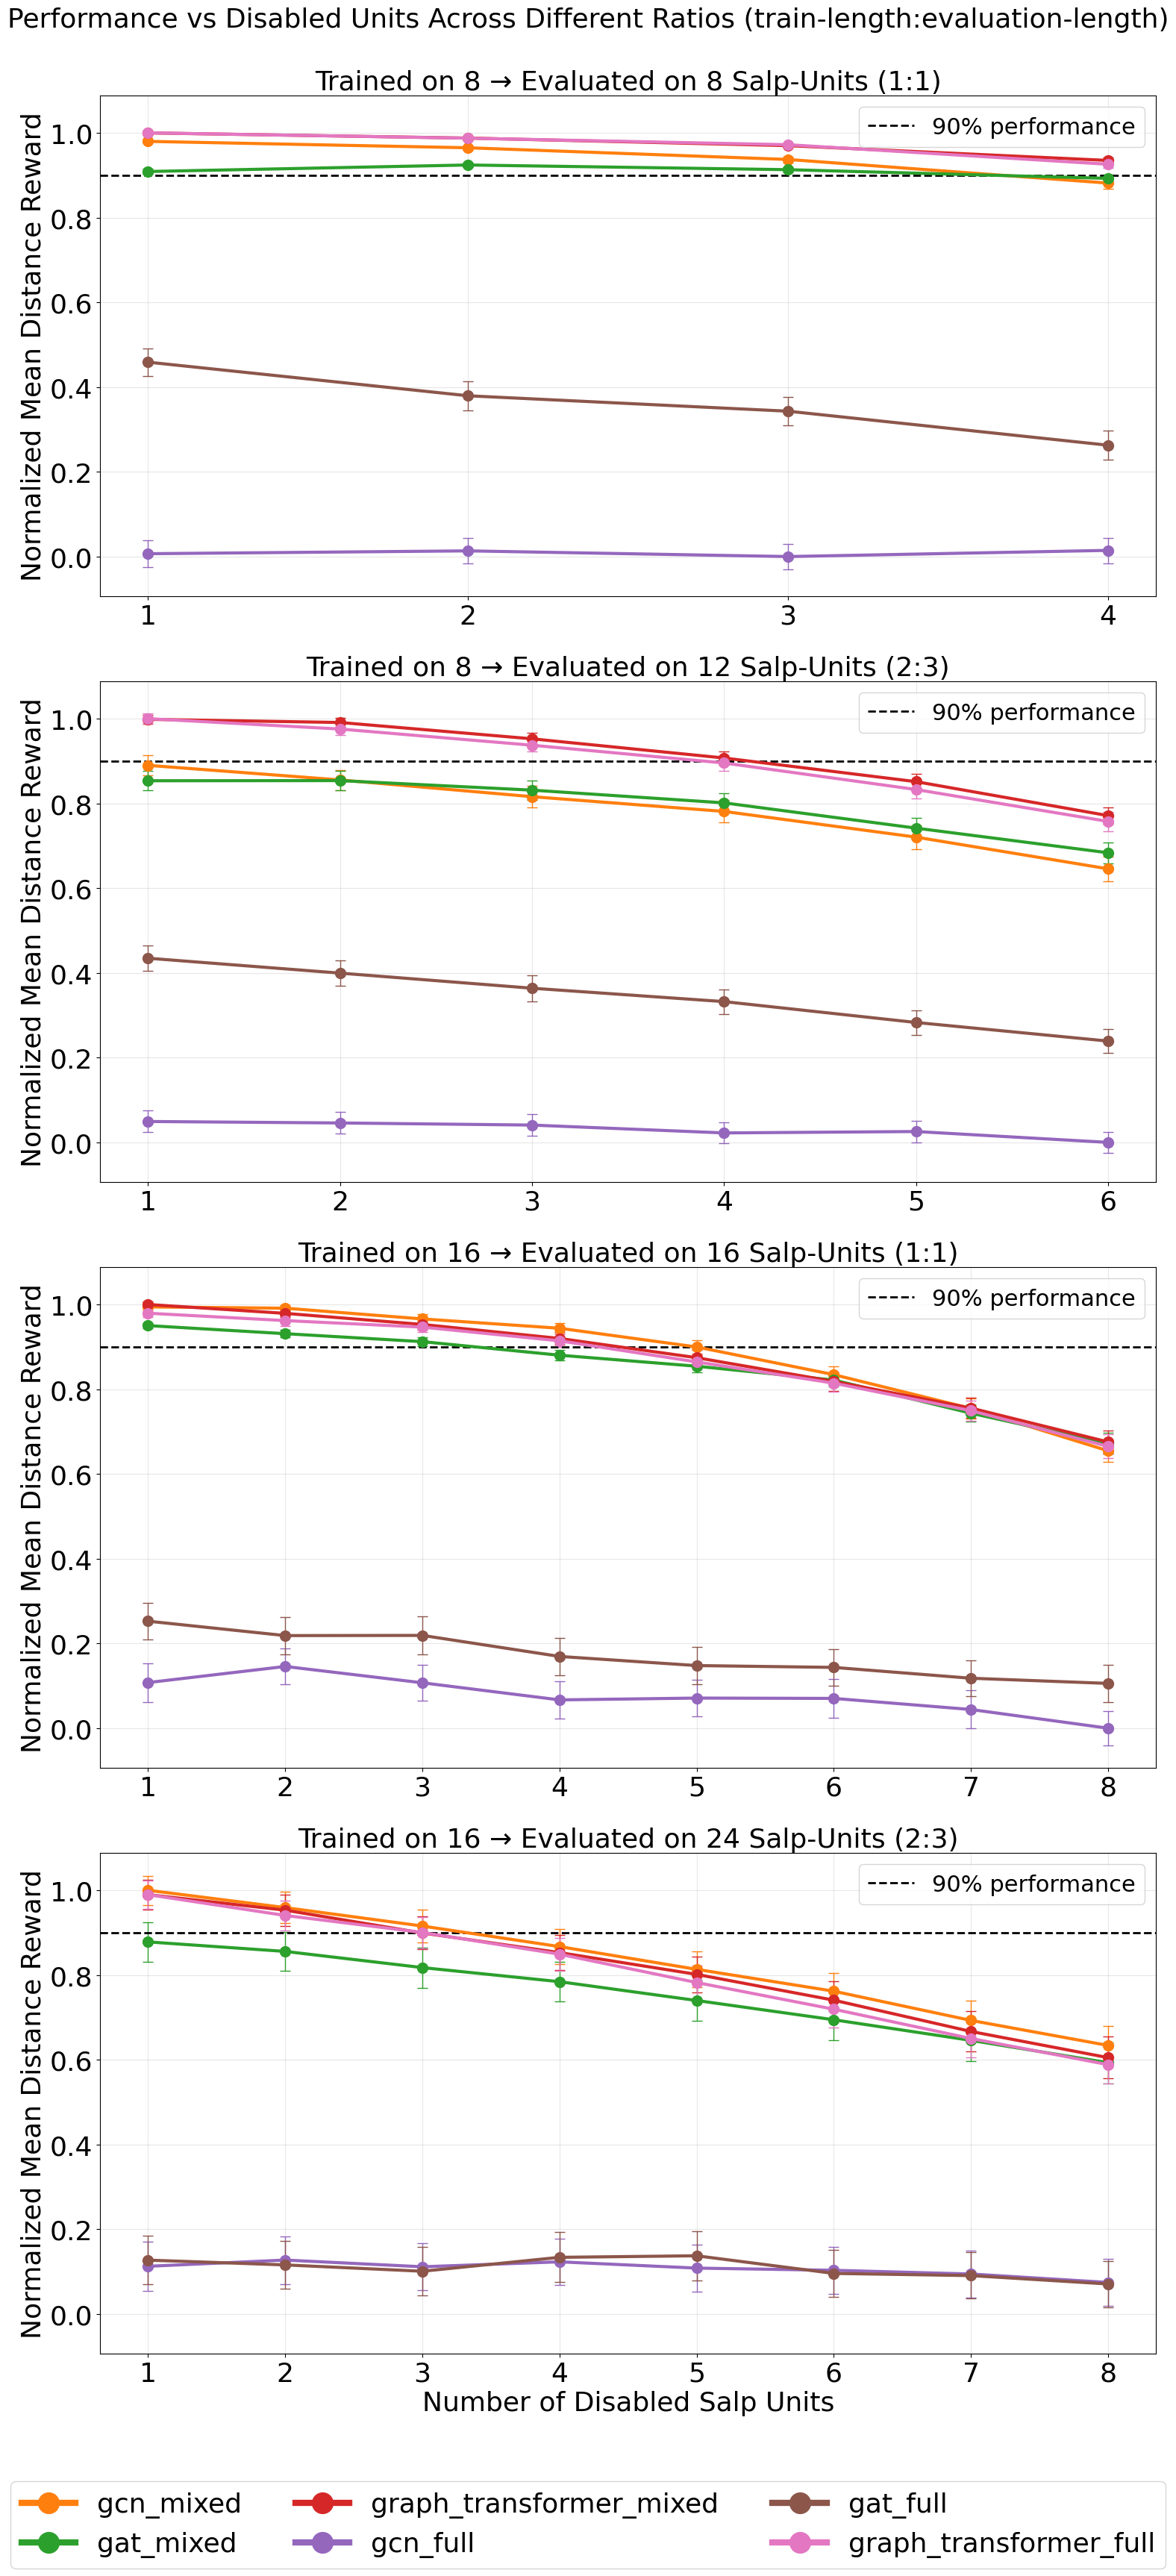

In [6]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import yaml
import pickle
from collections import defaultdict

# Set font properties for entire plot
fontsize=26
plt.rcParams.update({
    'font.size': fontsize,
    'axes.labelsize': fontsize,
    'axes.titlesize': fontsize,
    'legend.fontsize': fontsize,
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize,
})

from math import gcd

plotting_dir = Path().resolve()
config_dir = plotting_dir / "ppo_config.yaml"

with open(config_dir, "r") as file:
    config = yaml.safe_load(file)

# Group data by batch first, then by experiment, then by n_agents, then by disabled_units
batch_data = {batch: defaultdict(lambda: defaultdict(lambda: defaultdict(list))) for batch in config["batches"]}
reward_name = "dist_rewards"

# First, collect all data points across trials
for batch in config["batches"]:
    for experiment in config["experiments"]:
        for trial in config["trials"]:
            evaluation_file_name = f"disabled_mask_eval"
            checkpoint_path = Path(f"{config['base_path']}/{batch}/{experiment}/{trial}/logs/{evaluation_file_name}.dat")

            if checkpoint_path.is_file():
                with open(checkpoint_path, "rb") as handle:
                    data = pickle.load(handle)
                    
                    # data structure: {n_agents: {disabled_units: {'dist_rewards': [...], ...}}}
                    for n_agents in data.keys():
                        for disabled_units in data[n_agents].keys():
                            # Append rewards from this trial to the list
                            batch_data[batch][experiment][n_agents][disabled_units].extend(
                                data[n_agents][disabled_units][reward_name]
                            )
                        
                print(f"Added trial {trial} data to {batch}/{experiment}")

# Extract training sizes from batch names
batch_training_sizes = {}
for batch in config["batches"]:
    if "8" in batch or batch == config["batches"][0]:
        batch_training_sizes[batch] = 8
    elif "16" in batch or batch == config["batches"][1]:
        batch_training_sizes[batch] = 16

# Group by scale factor (evaluation_size / training_size)
scale_factor_data = defaultdict(list)  # {scale_factor: [(batch, n_agents), ...]}

for batch in config["batches"]:
    training_size = batch_training_sizes[batch]
    for experiment in config["experiments"]:
        for n_agents in batch_data[batch][experiment].keys():
            scale_factor = n_agents / training_size
            scale_factor_data[scale_factor].append((batch, n_agents, experiment))

# Sort scale factors
sorted_scale_factors = sorted(scale_factor_data.keys())

# Collect all subplot information
subplot_info = []  # List of (scale_factor, batch, n_agents) tuples

for scale_factor in sorted_scale_factors:
    batch_agent_pairs = scale_factor_data[scale_factor]
    unique_batches = list(set([batch for batch, _, _ in batch_agent_pairs]))
    
    for batch in unique_batches:
        # Get n_agents for this batch at this scale factor
        n_agents = None
        for b, n, _ in batch_agent_pairs:
            if b == batch:
                n_agents = n
                break
        if n_agents is not None:
            # Calculate reduced ratio
            training_size = batch_training_sizes[batch]
            ratio_gcd = gcd(training_size, n_agents)
            reduced_training = training_size // ratio_gcd
            reduced_n_agents = n_agents // ratio_gcd
            
            # Only include ratios 1:1 and 2:3
            if (reduced_training == 1 and reduced_n_agents == 1) or \
               (reduced_training == 2 and reduced_n_agents == 3):
                subplot_info.append((scale_factor, batch, n_agents))

# Create one large 4x1 figure (stacked vertically)
fig, axes = plt.subplots(4, 1, figsize=(16, 34), sharey=True)  # Remove sharex=True

# Use a different color for each experiment
experiment_colors = {}
color_idx = 0

# Store line objects and labels for shared legend
all_lines = []
all_labels = ["gcn_mixed", "gat_mixed", "graph_transformer_mixed", "gcn_full", "gat_full", "graph_transformer_full"]

# Calculate normalization parameters for each [batch][n_agents] combination
normalization_params = {}

for batch in config["batches"]:
    normalization_params[batch] = {}
    for experiment in config["experiments"]:
        for n_agents in batch_data[batch][experiment].keys():
            if n_agents not in normalization_params[batch]:
                # First time seeing this n_agents for this batch
                # Collect all means across all experiments for this [batch][n_agents]
                all_means_for_batch_nagents = []
                
                for exp in config["experiments"]:
                    if n_agents in batch_data[batch][exp]:
                        disabled_units_list = sorted(batch_data[batch][exp][n_agents].keys())
                        for disabled_units in disabled_units_list:
                            rewards = batch_data[batch][exp][n_agents][disabled_units]
                            if rewards:
                                all_means_for_batch_nagents.append(np.mean(rewards))
                
                # Calculate normalization parameters for this [batch][n_agents]
                if all_means_for_batch_nagents and max(all_means_for_batch_nagents) != min(all_means_for_batch_nagents):
                    min_mean = min(all_means_for_batch_nagents)
                    max_mean = max(all_means_for_batch_nagents)
                    range_mean = max_mean - min_mean
                else:
                    min_mean = 0
                    range_mean = 1
                
                normalization_params[batch][n_agents] = {
                    'min': min_mean,
                    'range': range_mean
                }

# Sort subplot_info by training size first, then by ratio
# This ensures: 8-unit (1:1), 8-unit (2:3), 16-unit (1:1), 16-unit (2:3)
subplot_info_sorted = sorted(subplot_info, key=lambda x: (batch_training_sizes[x[1]], x[2]))

# Plot each subplot
for subplot_idx, (scale_factor, batch, n_agents) in enumerate(subplot_info_sorted):
    if subplot_idx >= 4:  # Only 4 subplots in 4x1 grid
        break
    
    ax = axes[subplot_idx]

    # Get training size for this batch
    training_size = batch_training_sizes[batch]
    
    # Calculate reduced ratio
    ratio_gcd = gcd(training_size, n_agents)
    reduced_training = training_size // ratio_gcd
    reduced_n_agents = n_agents // ratio_gcd
    
    # Set subplot title with reduced ratio
    ax.set_title(f"Trained on {training_size} → Evaluated on {n_agents} Salp-Units ({reduced_training}:{reduced_n_agents})")
    
    # Set y-label for all plots
    ax.set_ylabel("Normalized Mean Distance Reward")
    
    # Get normalization parameters for this [batch][n_agents]
    min_mean = normalization_params[batch][n_agents]['min']
    range_mean = normalization_params[batch][n_agents]['range']
    
    # Collect experiment data
    experiment_data = {}
    current_subplot_xticks = None  # Track x-ticks for this specific subplot
    
    for experiment in config["experiments"]:
        # Skip if no data for this experiment and n_agents
        if n_agents not in batch_data[batch][experiment]:
            print(f"No data for {batch}/{experiment}/n_agents={n_agents}")
            continue
        
        # Get sorted list of disabled unit counts
        disabled_units_list = sorted(batch_data[batch][experiment][n_agents].keys())
        
        if not disabled_units_list:
            continue
        
        # Store the first valid disabled_units_list for x-ticks
        if current_subplot_xticks is None:
            current_subplot_xticks = disabled_units_list[:8]
        
        # Calculate mean and standard error for each disabled_units count
        means = []
        errors = []
        for disabled_units in disabled_units_list:
            rewards = batch_data[batch][experiment][n_agents][disabled_units]
            if rewards:
                means.append(np.mean(rewards))
                errors.append(np.std(rewards) / np.sqrt(len(rewards)))
            else:
                means.append(0)
                errors.append(0)
        
        experiment_data[experiment] = {
            'disabled_units': disabled_units_list,
            'means': means,
            'errors': errors
        }
    
    # Plot with [batch][n_agents]-specific normalization
    for experiment in config["experiments"]:
        if experiment not in experiment_data:
            continue
            
        # Get consistent color for this experiment
        if experiment not in experiment_colors:
            experiment_colors[experiment] = plt.cm.tab10(color_idx+1 % 10)
            color_idx += 1
        color = experiment_colors[experiment]
        
        data = experiment_data[experiment]
        disabled_units_list = data['disabled_units']
        means = data['means']
        errors = data['errors']
        
        # Normalize using [batch][n_agents]-specific min/max
        if range_mean > 0:
            normalized_means = [(m - min_mean) / range_mean for m in means]
            normalized_errors = [e / range_mean for e in errors]
        else:
            normalized_means = means
            normalized_errors = errors
        
        # Print sample counts
        sample_counts = [len(batch_data[batch][experiment][n_agents][d]) for d in disabled_units_list]
        print(f"{batch}/{experiment}/n_agents={n_agents}: {sample_counts} samples per disabled count")
        
        # Plot with error bars
        line = ax.errorbar(
            disabled_units_list[:8],
            normalized_means[:8],
            yerr=normalized_errors[:8],
            fmt="o-",
            linewidth=3,
            elinewidth=1,
            markersize=10,
            capsize=5,
            color=color,
            ecolor=color,
            label=experiment
        )
        
        # Store line and label for shared legend (only from first subplot)
        if subplot_idx == 0:
            all_lines.append(line[0])
    
    # Only add x-label to bottom subplot
    if subplot_idx == 3:  # Bottom subplot (index 3 out of 0-3)
        ax.set_xlabel("Number of Disabled Salp Units")
    
    # Set x-ticks for this specific subplot
    if current_subplot_xticks:
        ax.set_xticks(current_subplot_xticks)
    
    ax.grid(True, alpha=0.3)

    # Add horizontal line at 0.90
    line_90 = ax.axhline(y=0.90, color='black', linestyle='--', linewidth=2)
    
    # Add legend only for the horizontal line in each subplot
    ax.legend([line_90], ['90% performance'], loc='upper right', fontsize=22)

# Create a single legend for the entire figure
leg = fig.legend(all_lines, all_labels, 
           loc='lower center',  
           bbox_to_anchor=(0.5, -0.02),  
           ncol=3,  # 3 columns for better layout
           markerscale=2)

# Make legend lines thicker
for line in leg.get_lines():
    line.set_linewidth(6)  # Adjust thickness here

# Add overall title
fig.suptitle(f"Performance vs Disabled Units Across Different Ratios (train-length:evaluation-length)", 
             fontsize=26, y=0.995)

# Adjust layout to make room for the legend and title
plt.tight_layout()
plt.subplots_adjust(bottom=0.07, top=0.96)

plt.savefig(f"performance_vs_disabled_units_stacked.png", dpi=800, bbox_inches="tight")
plt.show()